<a href="https://colab.research.google.com/github/daonly/personal/blob/main/rsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Representational Similarity Analysis (RSA)
- 서로 다른 유형의 데이터 (e.g. 뇌, 행동)를 유사성 매트릭스를 기반으로 연결할 수 있는 분석 방식
    - Kriegeskorte, Mur, and Bandettini, 2008 (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2605405/)

- 신경 패턴 유사성과 행동, 설문지 또는 모델 간의 상관관계
    - 연구자가 예상하는 모델을 표상하는 영역을 찾거나 (model based RSA), 사람들 간의 행동의 유사성을 표상하는 영역을 찾을 수 있음 (Inter-subject RSA)

## 2-1. Steps in applying RSA to fMRI data

1. 실험 조건들에 대한 뇌 활성 패턴 추정
2. 관심 영역에서 활동 패턴의 차이를 반영하는 유사성 매트릭스 구성 (neural RDM)
3. 행동 데이터 혹은 연구자의 모델에 기반한 유사성 매트릭스 구성 (behavioral RDM)
4. 2와 3의 비교


<img src= 'https://drive.google.com/uc?id=1WQ7skUXkRXPkQINpcNneAC9Qo3mRY-7U' width=600>

- IS-RSA 의 경우 2, 3에서 RDM 구성 시 참가자 간 유사성을 계산

## 2-2. Representational Dissimilarity Matrix (RDM)
- 서로 다른 표상이 얼마나 다른지를 나타내는 대칭 행렬
    - model RDM: 연구자가 가지고 있는 가설에 따라 각 조건간 표상의 유사성에 대한 모델을 행렬로 수치화
    - neural RDM: 뇌에서의 표상 간 유사성을 행렬로 수치화

        <img src= 'https://drive.google.com/uc?id=1UDFF9ZaHHqFoWz1hfdpFWV7VPYo6QwTV' width=600>


## 2-3. Measuring dissimilarity (distance)
- Eucledian distance:
$d\left(a,b\right)   = \sqrt {\sum _{i=1}^{n}  \left( a_{i}-b_{i}\right)^2 }$
- Correlation distance: $1-corr(a,b)$

### Distance <-> Similarity
- Eucledian distance의 유사성 = $exp(-distance / σ)$
    - 거리가 멀어질수록 유사성이 0으로 수렴하고, 거리가 0에 가까워질수록 유사성이 1로 수렴하는 특성
- Correlation distance의 유사성 = r

## 2-4. Application

### Goal of the session
- Model based RSA
    - 사회적 거리의 가까운 정도를 표상하는 영역 찾기
- Inter-subject RSA
    - 참가자 간 다양한 사회적 거리의 대상에 대한 표상의 패턴을 반영하는 뇌영역 찾기

### Mount drive/ set path

In [6]:
from google.colab import drive
drive.mount('/content/drive')

bids_dir = '/content/drive/MyDrive/Colab Notebooks/2023_BK_seminar'

import os

data_dir = os.path.join(bids_dir,'derivatives','data','contrasts')
analysis_dir = os.path.join(bids_dir, 'derivatives','rsa')
material_dir = os.path.join(bids_dir, 'materials')

if not os.path.exists(analysis_dir):
    os.makedirs(analysis_dir)

os.chdir(analysis_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Download dataset
- directory structure:
    - /derivatives/data/
        - contrasts/SD_x_xxx.nii
        - SD_likeRating.xlsx

In [7]:
# #### download necessary dataset ####
# if not os.path.exists(data_dir):
#   os.makedirs(data_dir)

# if not os.path.exists(os.path.join(data_dir,'subset2.zip')):
#     ###!pip install pydrive
#     print('\n\n')
#     from pydrive.auth import GoogleAuth
#     from pydrive.drive import GoogleDrive
#     from google.colab import auth
#     from oauth2client.client import GoogleCredentials
#     auth.authenticate_user()
#     gauth = GoogleAuth()
#     gauth.credentials = GoogleCredentials.get_application_default()
#     drive = GoogleDrive(gauth)


#     # Downloading the data from Google drive link
#     os.chdir(data_dir)
#     data_zip = drive.CreateFile({'id':'1OmPX1d5zNpL27hCgONm8MGyxPLHwm0G-'})
#     data_zip.GetContentFile('subset2.zip')
#     !unzip -j subset2.zip

#     print('\n ==> Download & Unzip complete')

# else:
#     print('\n ==> Data exists')

### Import packages

- https://nltools.org/index.html

- 파이썬을 활용한 fMRI 데이터 분석 패키지
- nilearn 에서 제공하는 함수들을 wrapping해 쉬운 코딩이 가능
- RSA에 활용하기 편한 형태의 class 제공

In [8]:
### import libraries
import os, glob
import numpy as np
import pandas as pd

!pip install nltools
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask

### Loading ROI masks
- functional parcellation atlas (50 parcels)

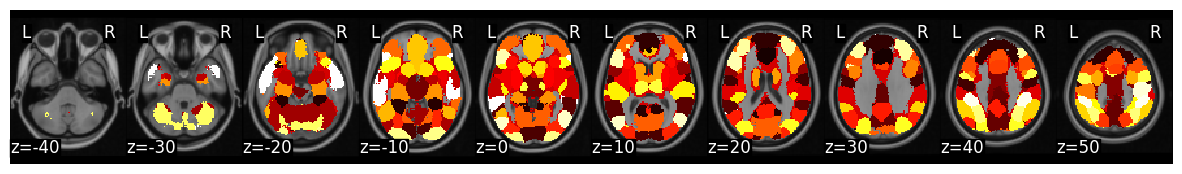

In [9]:
# check mask
mask = Brain_Data(os.path.join(material_dir, 'k50.nii.gz'))
mask.plot()
masks = expand_mask(mask)

#Model based RSA

## 1. Building model RDM (representational dissimilarity matrix)


- 가정(행동 모델): 나와 가까운 정도에 따라 표상의 구조가 달라질 것
    - 예) 5번째 가까운 사람과 10번째 가까운 사람의 표상이 5번째로 가까운 사람과 20번째로 가까운 사람의 표상보다 유사할 것
    - 5번째, 10번째 대상의 거리 = 5
    - 5번째, 20번째 대상의 거리 = 15
- 행동 모델에 따라 뇌 활성의 표상이 달라지는 영역 찾기

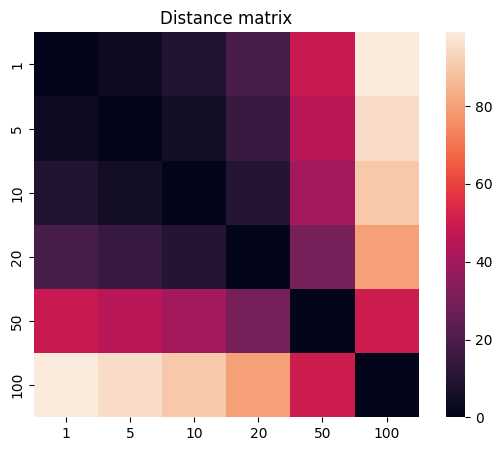

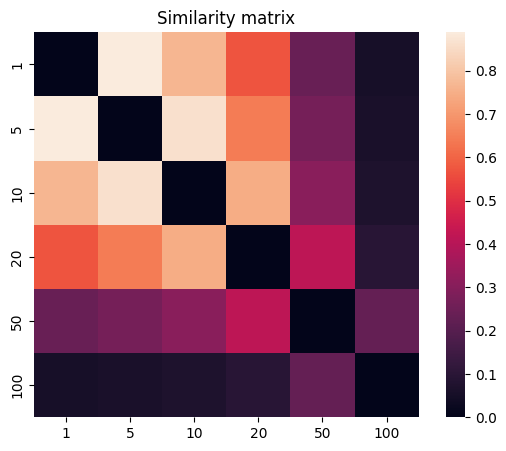

In [10]:
import matplotlib.pyplot as plt

sub_list = [f"{x+1:03}" for x in np.arange(20)]

conditions = glob.glob(os.path.join(data_dir, f'SD*001.nii'))
conditions = [os.path.basename(x).split('_')[1] for x in conditions]
conditions = sorted(conditions, key=lambda x: int(x))

# where
model = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        model[i][j] = abs(int(conditions[i])-int(conditions[j])) # euclidean distance for each pair

model = Adjacency(model, matrix_type = 'distance', labels=conditions)
model.plot()
plt.title("Distance matrix")
plt.show()

model = model.distance_to_similarity(metric='euclidean')
# correlation 일 경우에는 1-r 로 계산,
# euclidean 일 경우에는 거리들의 표준편차로 정규화, -를 붙이고, exponential을 씌움, 0~1 사이의 값으로 만들기 위함
model.plot()
plt.title("Similarity matrix")
plt.show()


## 2. Building neural RDM
- 관심 영역에서 조건들의 표상이 얼마나 다른지를 나타내는 2차원 행렬 (조건 수 x 조건 수)
- 1명의 피험자 마다, 50개의 영역마다 6 x 6의 행렬을 계산

## 3. Comparing brain & model RDM
- 피험자마다, 각 영역마다 계산된 RDM과 model RDM의 상관을 계산


In [11]:
# from matplotlib.cbook import simple_linear_interpolation

# preallocate
all_sub_similarity = {};
all_sub_model_rsa = {};

for sub in sub_list: # Extract beta maps for each subject
    file_list = glob.glob(os.path.join(data_dir, f'SD*{sub}.nii'))
    file_list.sort()
    conditions = [os.path.basename(x).split('_')[1] for x in file_list]
    beta = Brain_Data(file_list)

    sub_pattern = []; model_sim_r = [];
    for m in masks: # extract activity pattern for each mask, compute correlation, build rdm
        sub_pattern_similarity = 1 - beta.apply_mask(m).distance(metric='correlation') # .distance에서 이미 1-r을 계산하므로, 유사성 matrix로 만들기 위해서는 다시 1에서 빼줌
        sub_pattern_similarity.labels = conditions
        model_brain_similarity = sub_pattern_similarity.similarity(model, metric='spearman', n_permute=0) # calculate similarity with model matrix, defualt permutation option = 500
        sub_pattern.append(sub_pattern_similarity)
        model_sim_r.append(model_brain_similarity['correlation'])

    all_sub_similarity[sub] = sub_pattern
    all_sub_model_rsa[sub] = model_sim_r
all_sub_model_rsa = pd.DataFrame(all_sub_model_rsa).T
print(all_sub_model_rsa.head(10))

/usr/local/lib/python3.10/dist-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/usr/local/lib/python3.10/dist-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/usr/local/lib/python3.10/dist-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and p

           0         1         2         3         4         5         6   \
001 -0.232143 -0.257143 -0.292857 -0.285714 -0.217857 -0.167857  0.114286   
002  0.239286  0.107143  0.564286  0.317857 -0.035714  0.171429  0.250000   
003 -0.060714  0.285714  0.135714  0.303571 -0.192857  0.064286 -0.078571   
004 -0.289286  0.271429 -0.110714  0.510714 -0.200000  0.610714 -0.092857   
005 -0.221429 -0.135714 -0.257143 -0.039286 -0.096429 -0.050000 -0.239286   
006 -0.371429  0.278571 -0.489286 -0.157143 -0.085714 -0.339286 -0.375000   
007 -0.032143 -0.371429 -0.310714 -0.307143 -0.189286 -0.267857 -0.407143   
008 -0.275000 -0.114286  0.075000  0.485714 -0.035714  0.321429 -0.039286   
009 -0.332143 -0.285714 -0.385714 -0.075000 -0.389286 -0.192857 -0.182143   
010 -0.232143 -0.200000 -0.196429 -0.160714 -0.135714 -0.182143 -0.375000   

           7         8         9   ...        40        41        42  \
001 -0.264286 -0.239286 -0.182143  ... -0.028571 -0.250000 -0.157143   
002 -0.1

/usr/local/lib/python3.10/dist-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


In [12]:
# one sample t-test on each ROI

# 1. fisher's r-to-z transform
from nltools.stats import fisher_r_to_z, one_sample_permutation

rsa_stats=[]
for i in all_sub_model_rsa:
    rsa_stats.append(one_sample_permutation(fisher_r_to_z(all_sub_model_rsa[i]),
                                            n_permute=5000,
                                            return_perms=True)) # permutation distribution도 저장

/usr/local/lib/python3.10/dist-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


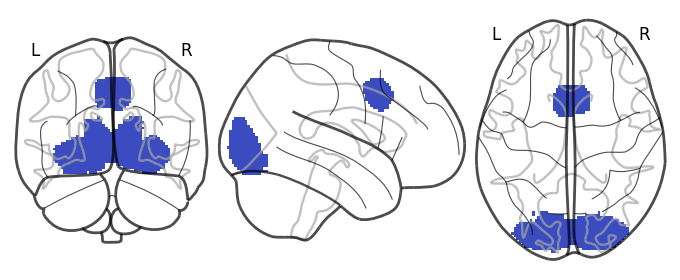

In [13]:
# fdr correction
from nltools.stats import fdr, threshold
from nltools.plotting import plot_glass_brain

fdr_p = fdr(np.array([x['p'] for x in rsa_stats]), q=.05) # find p threshold

rsa_model_r = Brain_Data([x*y['mean'] for x, y in zip (masks, rsa_stats)]).sum()
rsa_model_p = Brain_Data([x*y['p'] for x, y in zip(masks, rsa_stats)]).sum()

corrected = threshold(rsa_model_r, rsa_model_p, thr=fdr_p)

plot_glass_brain(corrected.to_nifti(), cmap='coolwarm')

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



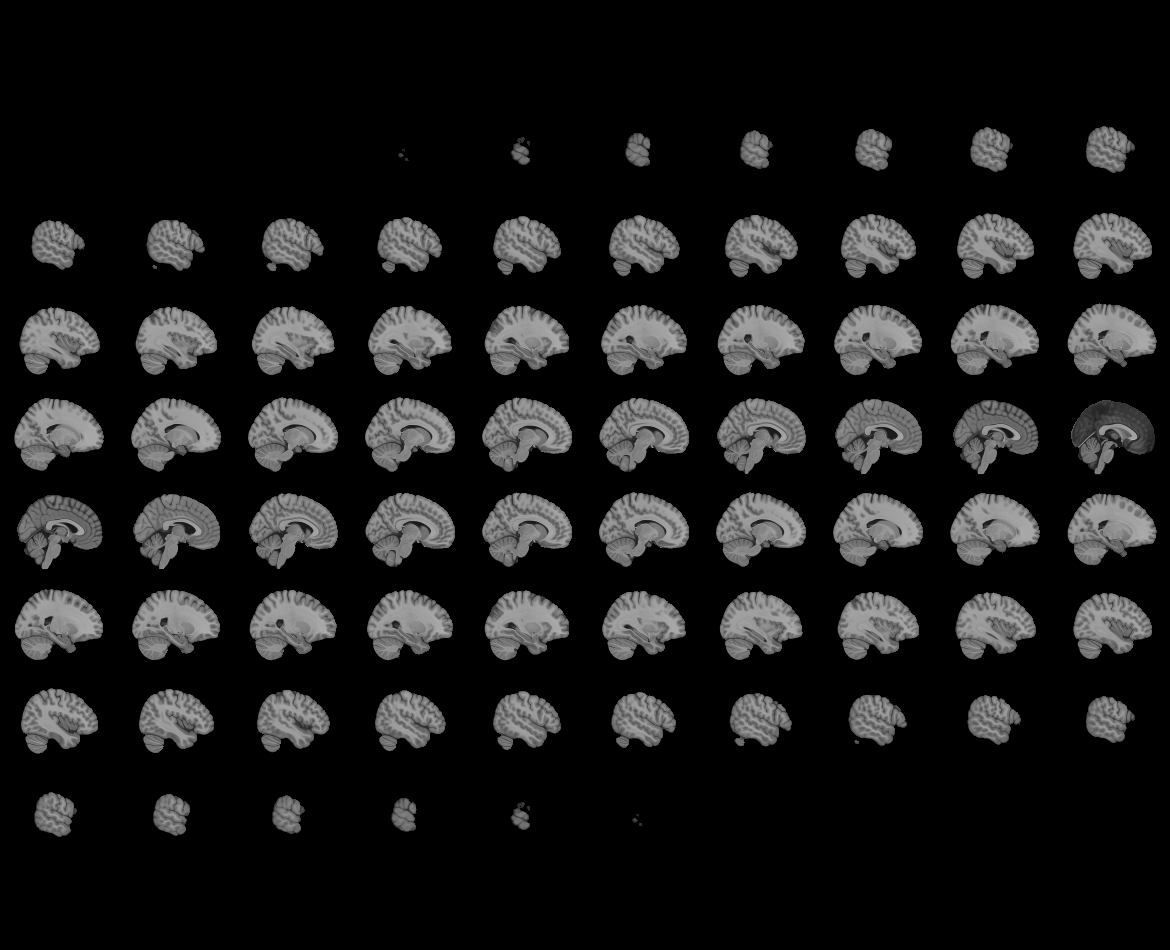
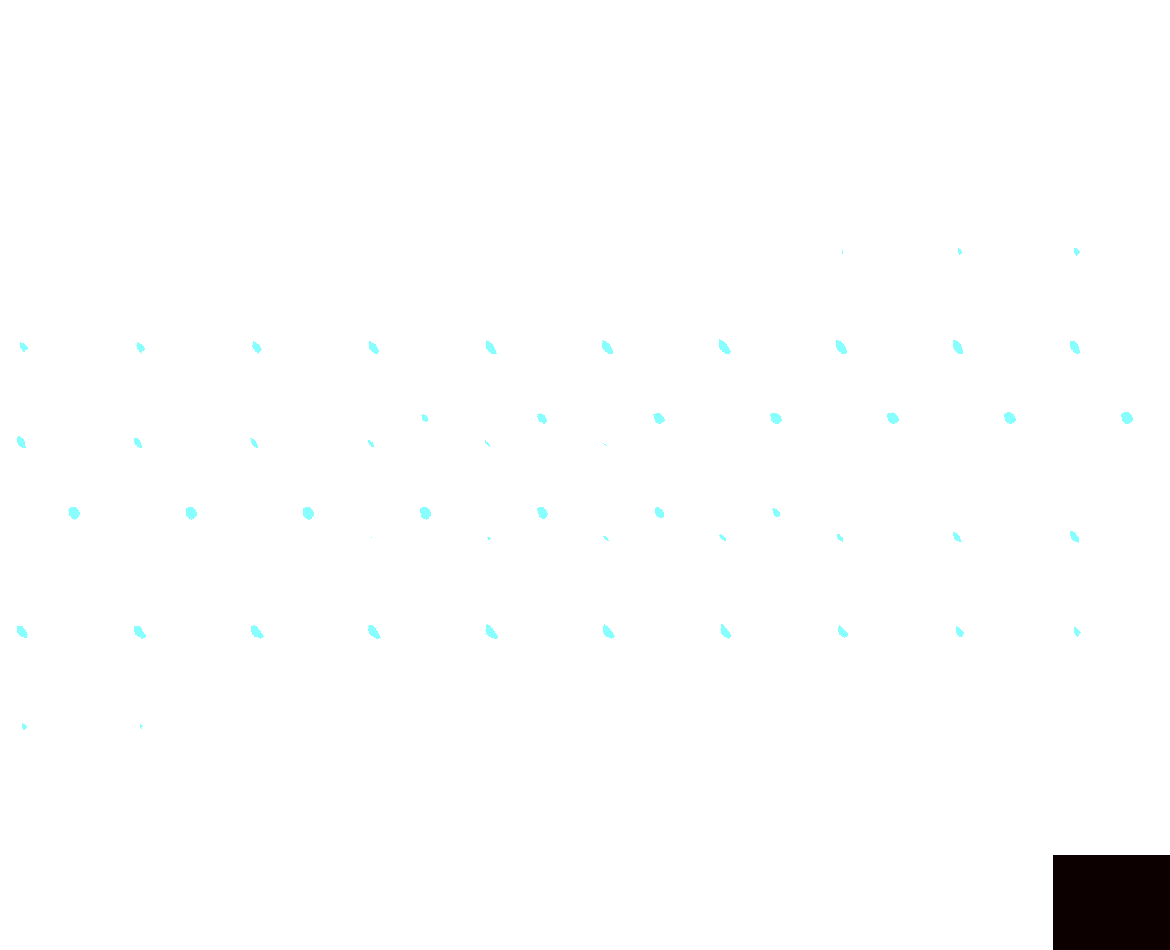

In [14]:
from nilearn.plotting import view_img

view_img(corrected.to_nifti())

In [ ]:
# check pattern in the result area
rsa_stats_df = pd.DataFrame(rsa_stats)
rsa_stats_df = rsa_stats_df.sort_values(['p'])

rsa_stats_df.head(3)


/usr/local/lib/python3.10/dist-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


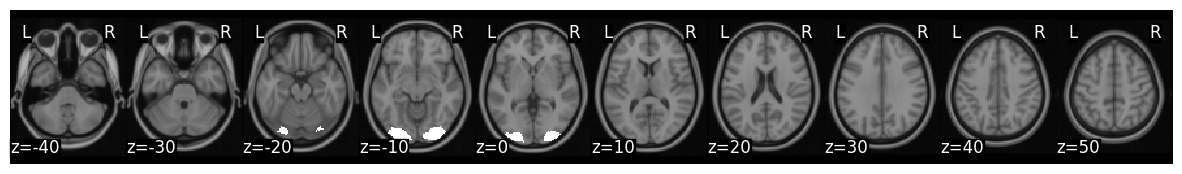

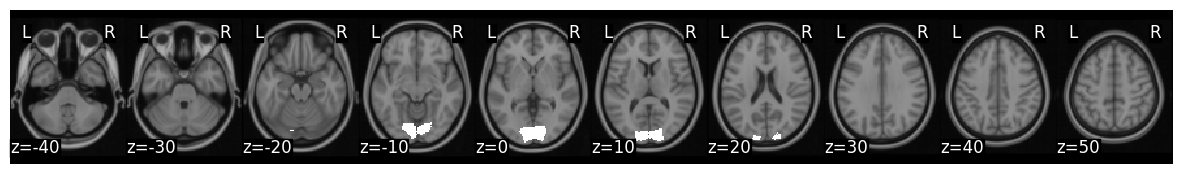

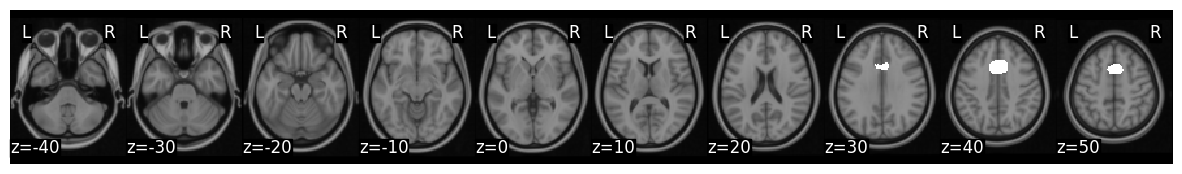

In [16]:
masks[43].plot()
masks[4].plot()
masks[22].plot()

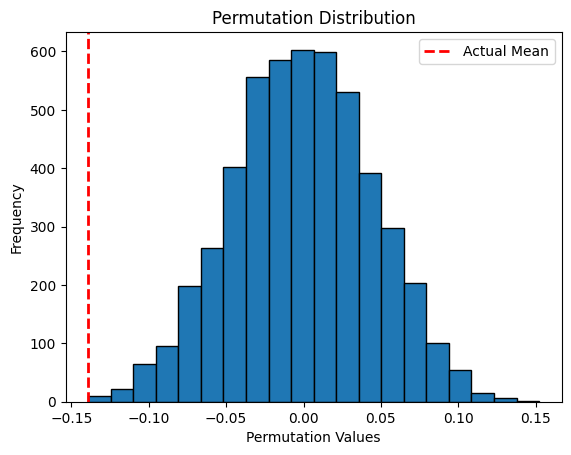

In [17]:
# permutation distribution 확인하기

import matplotlib.pyplot as plt

permutation_dist = rsa_stats[22]['perm_dist']

# 히스토그램으로 퍼뮤테이션 분포 그리기
plt.hist(permutation_dist, bins=20, edgecolor='black')
plt.xlabel('Permutation Values')
plt.ylabel('Frequency')
plt.title('Permutation Distribution')

plt.axvline(rsa_stats[22]['mean'], color='red', linestyle='dashed', linewidth=2, label='Actual Mean')

plt.legend()
plt.show()

<Axes: >

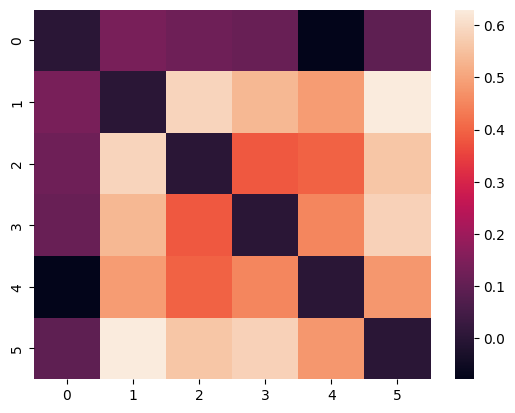

In [18]:
# 유의한 영역의 평균 RDM 확인하기

pattern_22 = []
for sub in all_sub_similarity.keys():
    pattern_22.append(all_sub_similarity[sub][22].data)

avg_pattern_22 = sum(pattern_22)/len(pattern_22)

from scipy.spatial.distance import squareform
avg_pattern_22 = squareform(avg_pattern_22)

import seaborn as sns
sns.heatmap(avg_pattern_22)

# IS-RSA

참가자간의 행동 지표의 거리를 RDM으로 구성

## Construct behavioral inter-subject RDM
- 행동 데이터:SD_likeRating.xlsx
    - 거리 별 대상 마다 호감도 평정치

In [19]:
# load behavior data

like_rating = pd.read_excel(os.path.join(bids_dir,'derivatives','data','SD_likeRating.xlsx'))[0:20]

KeyboardInterrupt: ignored

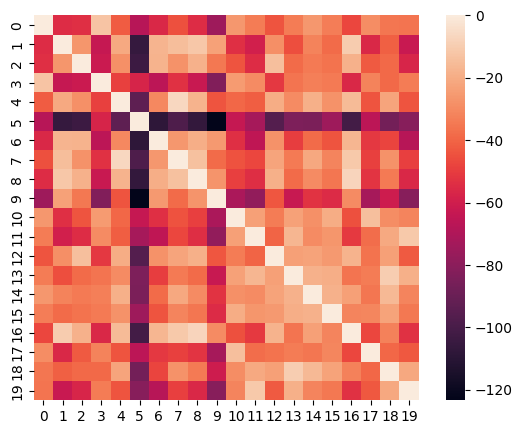

In [ ]:
# inter-subject similarity matrix

from sklearn.metrics import pairwise_distances

behav_is_sim = Adjacency(pairwise_distances(like_rating, metric='euclidean'), matrix_type='distance')
behav_is_sim = behav_is_sim.distance_to_similarity()
behav_is_sim.plot()


## Construct neural inter-subject RDM

In [ ]:
# concatenate brain data

all_roi_data={}

for n,m in enumerate(masks):
    all_roi_data[n] = pd.DataFrame()
    for sub in sub_list:
        files = glob.glob(os.path.join(data_dir, f'SD*{sub}.nii'))
        beta = Brain_Data(files)
        sub_roi_dat = beta.apply_mask(m).data.flatten() # mask 마다 참가자 간 거리를 구해야 하므로 mask 별로 brain data 저장
        all_roi_data[n][sub] = sub_roi_dat

    all_roi_data[n] = all_roi_data[n].T

/usr/local/lib/python3.10/dist-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/usr/local/lib/python3.10/dist-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)
/usr/local/lib/python3.10/dist-packages/nilearn/masking.py:975: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and p

In [ ]:
# mask 마다 참가자 간 neural RDM 계산 후 저장하기

similarity_matrices = []
for m in all_roi_data.keys():
    similarity_matrices.append(Adjacency(1 - pairwise_distances(all_roi_data[m], metric='correlation'), matrix_type='similarity'))
similarity_matrices = Adjacency(similarity_matrices)

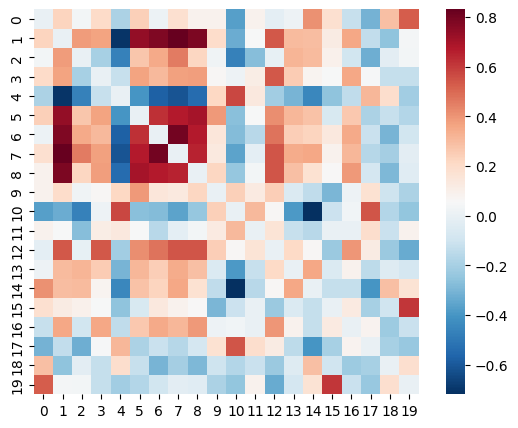

In [ ]:
# check
similarity_matrices[0].plot(cmap='RdBu_r')

## Compare behavioral & neural RDM

In [ ]:
# behavioral RDM과 mask 마다 correlation 계산
# compute intersubject rsa
# default = spearman, permutation

isrsa_all_roi_r, isrsa_all_roi_p = {}, {}
for n,m in enumerate(similarity_matrices):
    tmp_stat= similarity_matrices[n].similarity(behav_is_sim, metric='spearman', n_permute=1) # permute over 500!

    isrsa_all_roi_r[n] = tmp_stat['correlation']
    isrsa_all_roi_p[n] = tmp_stat['p']


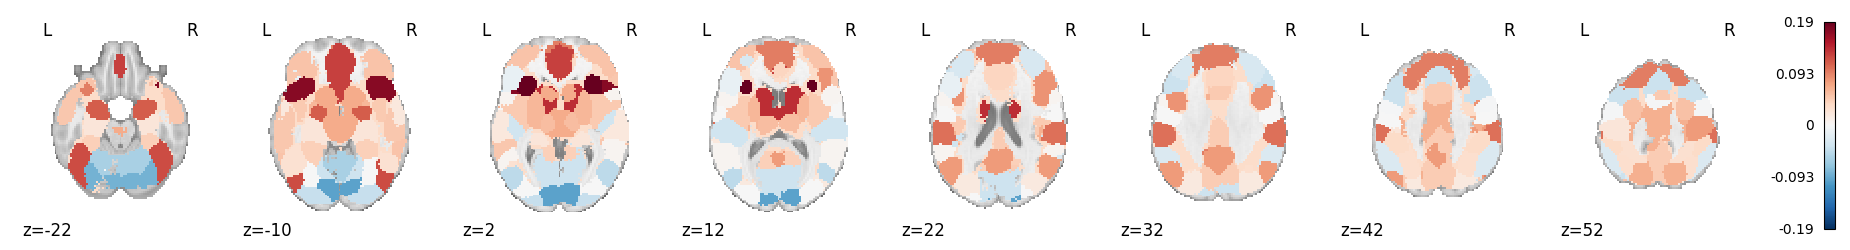

In [ ]:
# plot results

from nltools.mask import roi_to_brain
from nilearn.plotting import plot_stat_map

isrsa_r_brain = roi_to_brain(pd.Series(isrsa_all_roi_r), masks)
isrsa_p_brain = roi_to_brain(pd.Series(isrsa_all_roi_p), masks)
plot_stat_map(isrsa_r_brain.to_nifti(), display_mode='z', cut_coords=8, cmap='RdBu_r')


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



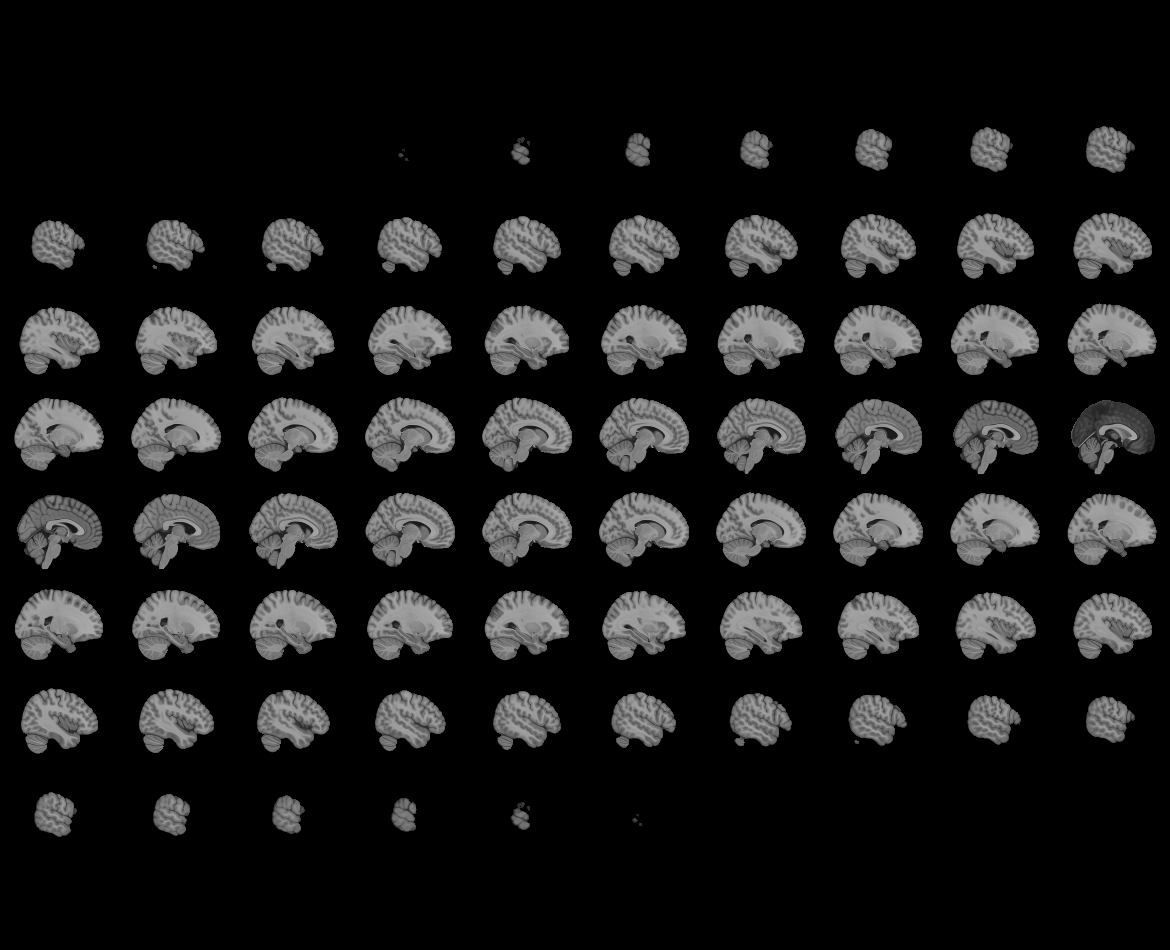
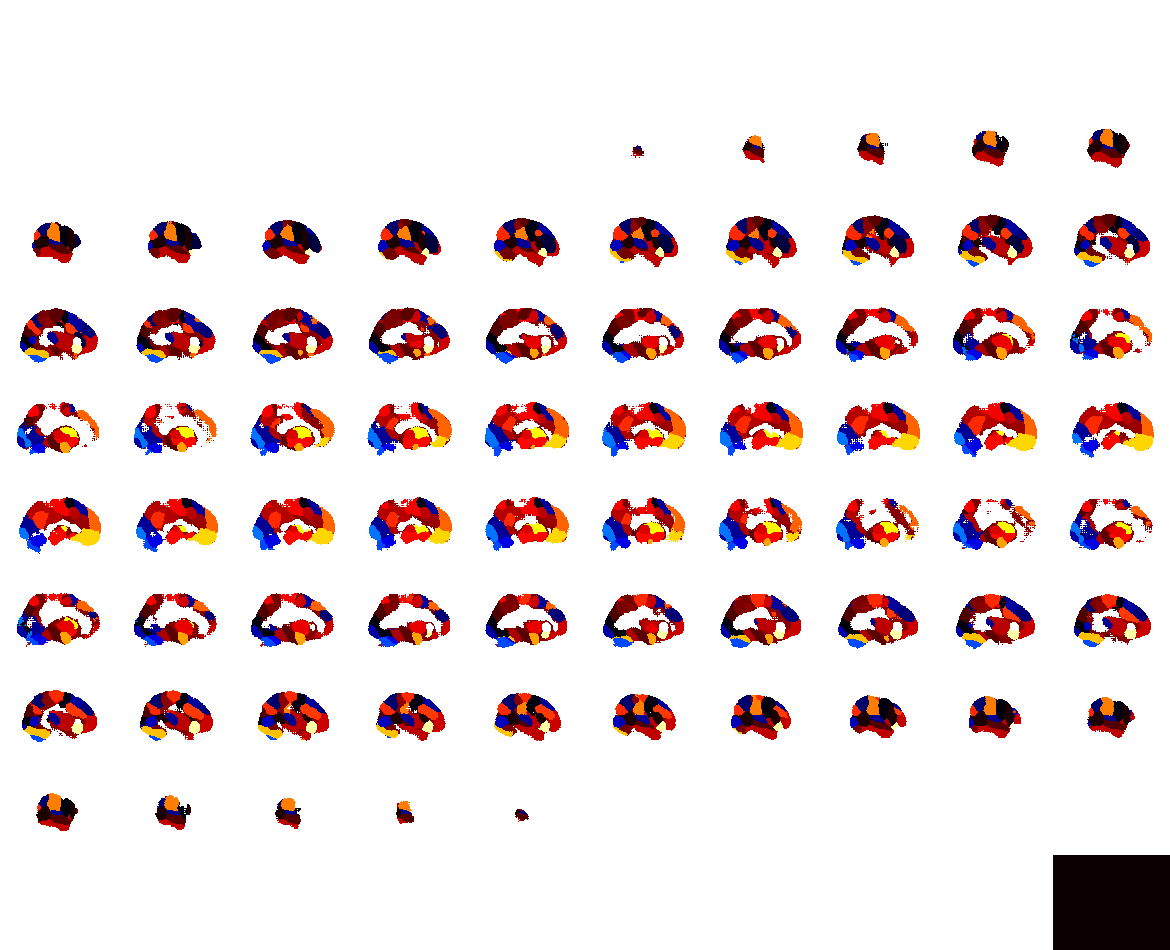

In [ ]:
from nilearn.plotting import view_img
view_img(isrsa_r_brain.to_nifti())


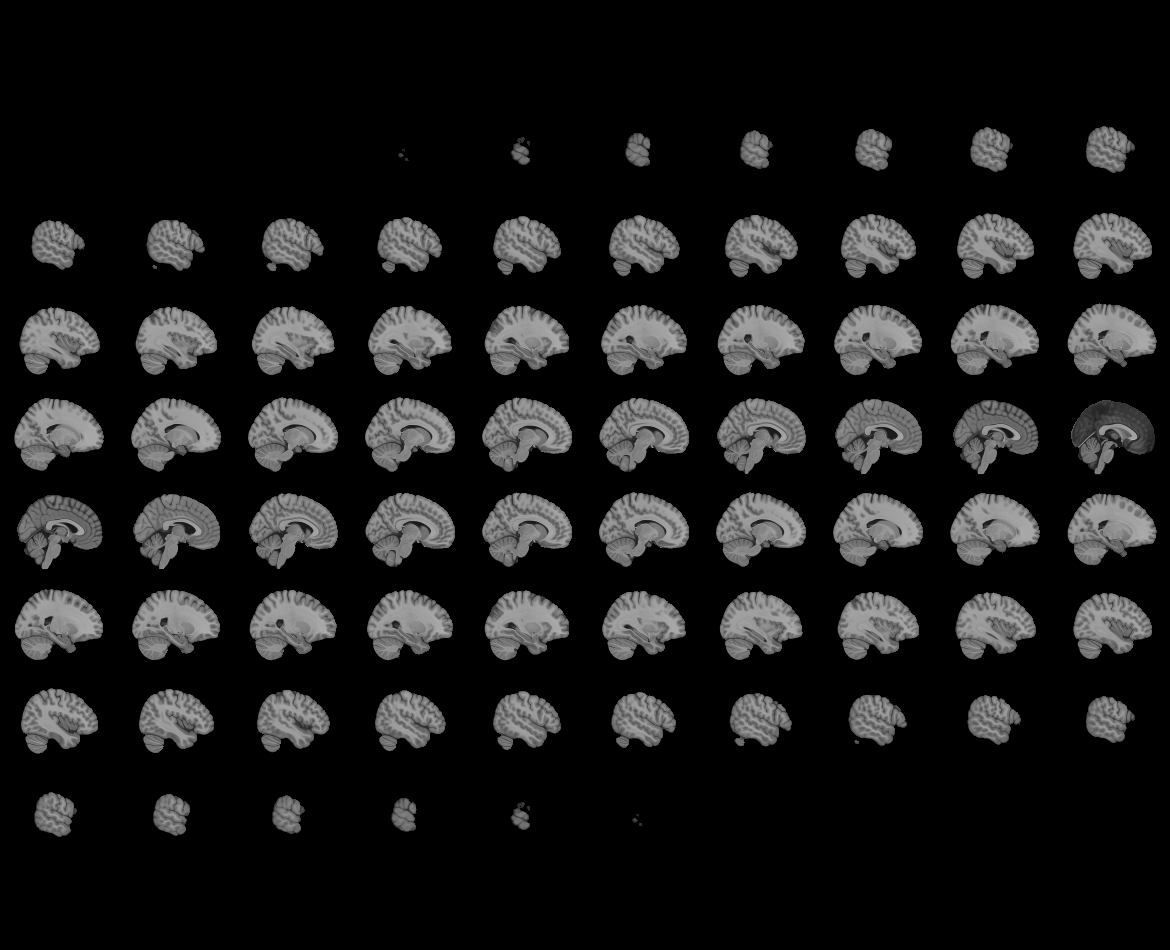
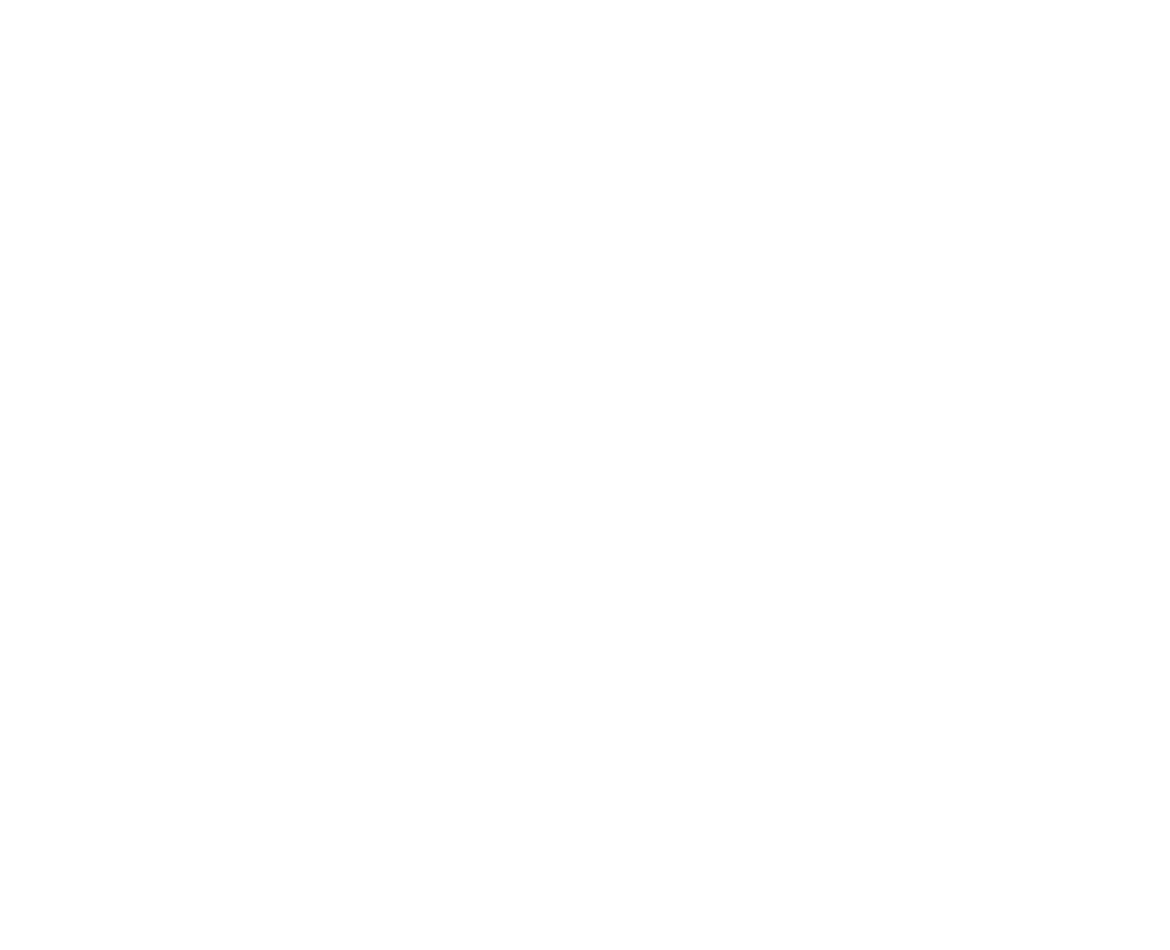

In [ ]:
# FDR threshold
from nltools.stats import fdr, threshold

fdr_thr = fdr(pd.Series(isrsa_all_roi_p).values, q = .05)

view_img(threshold(isrsa_r_brain, isrsa_p_brain, thr=fdr_thr).to_nifti())